# **Big Mart Sales Prediction Challenge**
---
### **Objective:**
Predict sales of products at different Big Mart stores using machine learning.

In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [127]:
# Define the filenames and variable names
dataset_names = [ "train_df", "test_df"]

# Load each dataset from CSV
datasets = {name: pd.read_csv(f"{name}.csv") for name in dataset_names}

# Unpack variables for direct usage
train_df = datasets["train_df"]
test_df = datasets["test_df"]

print("All datasets loaded successfully! 🎉")


All datasets loaded successfully! 🎉


In [122]:
import category_encoders as ce

# Define categorical columns to encode
cat_cols = ['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

# Initialize target encoder
target_encoder_3 = ce.TargetEncoder(cols=cat_cols)

# Fit on training data and transform both train and test data
train_df = train_df.copy()

train_df[cat_cols] = target_encoder_3.fit_transform(train_df[cat_cols], train_df['Item_Outlet_Sales'])

# Check encoded values
print(train_df[cat_cols].head())


   Outlet_Size  Outlet_Location_Type  Outlet_Type
0  2681.603542           1876.909159  2316.181148
1  2681.603542           2279.627651  1995.498739
2  2681.603542           1876.909159  2316.181148
3  1822.626947           2279.627651   339.828500
4  2298.995256           2279.627651  2316.181148


In [125]:
train_df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,2681.603542,1876.909159,2316.181148,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,2681.603542,2279.627651,1995.498739,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,2681.603542,1876.909159,2316.181148,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,1822.626947,2279.627651,339.828500,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,2298.995256,2279.627651,2316.181148,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,2298.995256,2279.627651,2316.181148,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,1822.626947,2323.990559,2316.181148,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,1912.149161,2323.990559,2316.181148,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,2681.603542,2279.627651,1995.498739,1845.5976


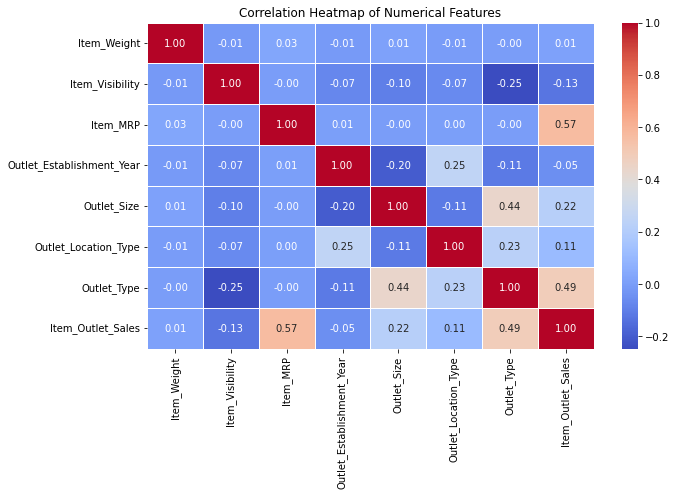

In [124]:

# Compute correlation matrix
corr_matrix = train_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


In [111]:
# no numerical features are highly correlated enough to justify dropping any of them.

In [112]:
#train_df.to_csv('cleaned_train.csv', index=False)
train_df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Item_Base', 'Z_Score',
       'IQR_Outlier', 'Z_Outlier', 'Visibility_Outlier', 'Outlet_Age',
       'Item_Category', 'Outlet_Identifier_Encoded'],
      dtype='object')

In [113]:
import os
print(os.getcwd())

/Users/uniquenetra/Documents/GitHub/BigMart-Sales-Prediction/notebooks


In [114]:
# Define columns to exclude from X_train
columns_to_exclude = [
    'Item_Outlet_Sales',  # Target variable
    'Item_Identifier', 
    'Outlet_Identifier', 
    'Z_Score', 
    'IQR_Outlier', 
    'Z_Outlier', 
    'Visibility_Outlier', 
    'Item_Base',  # Used only for imputing missing values
    'Item_Type',  # Redundant after categorization into Item_Category
    'Outlet_Establishment_Year'  # Replaced by Outlet_Age
]

# Create X_train and y_train without modifying train_df
X_train_clean = train_df.drop(columns=columns_to_exclude, errors='ignore')
y_train_clean = train_df['Item_Outlet_Sales']

# Check the shapes
print("X_train shape:", X_train_clean.shape)
print("y_train shape:", y_train_clean.shape)


X_train shape: (8523, 10)
y_train shape: (8523,)


In [115]:
X_train_clean

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Age,Item_Category,Outlet_Identifier_Encoded
0,9.300,Low Fat,0.016047,249.8092,2681.603542,1876.909159,2316.181148,10,Food,2348.354635
1,5.920,Regular,0.019278,48.2692,2681.603542,2279.627651,1995.498739,0,Drinks,1995.498739
2,17.500,Low Fat,0.016760,141.6180,2681.603542,1876.909159,2316.181148,10,Food,2348.354635
3,19.200,Regular,0.022861,182.0950,1867.182814,2279.627651,339.828500,11,Food,339.351662
4,8.930,Low Fat,0.006590,53.8614,2298.995256,2279.627651,2316.181148,22,Household,2298.995256
...,...,...,...,...,...,...,...,...,...,...
8518,6.865,Low Fat,0.056783,214.5218,2298.995256,2279.627651,2316.181148,22,Food,2298.995256
8519,8.380,Regular,0.046982,108.1570,1867.182814,2323.990559,2316.181148,7,Food,2192.384798
8520,10.600,Low Fat,0.035186,85.1224,1867.182814,2323.990559,2316.181148,5,Household,2438.841866
8521,7.210,Regular,0.145221,103.1332,2681.603542,2279.627651,1995.498739,0,Food,1995.498739


In [116]:
from sklearn.model_selection import train_test_split

# Splitting into training and validation sets
X_train, X_validate, y_train, y_validate = train_test_split(
    X_train_clean, y_train_clean, test_size=0.2, random_state=42
)

# Check the shape of the new splits
X_train.shape, X_validate.shape, y_train.shape, y_validate.shape


((6818, 10), (1705, 10), (6818,), (1705,))

In [117]:
X_train.select_dtypes(include=['object']).columns

Index(['Item_Fat_Content', 'Item_Category'], dtype='object')

In [118]:
# Applying label encoding for all the categorical varibales 

from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
print

# Apply Label Encoding
label_encoders = {}  # Store encoders to apply the same to validation data

X_train = X_train.copy()
X_validate = X_validate.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_train.loc[:, col] = le.fit_transform(X_train[col])
    label_encoders[col] = le  # Save the encoder for future use
    
    X_validate.loc[:, col] = label_encoders[col].transform(X_validate[col])  # Use same encoding


# Check encoded data
X_train.head()


,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Age,Item_Category,Outlet_Identifier_Encoded
549,9.500,1,0.035206,171.3448,2681.603542,1876.909159,2316.181148,10,1,2348.354635
7757,18.000,0,0.047473,170.5422,1867.182814,2323.990559,2316.181148,7,2,2192.384798
764,17.600,1,0.076122,111.7202,1867.182814,1876.909159,2316.181148,12,1,2277.844267
6867,8.325,0,0.029845,41.6138,1867.182814,2323.990559,2316.181148,7,1,2192.384798
2716,12.850,0,0.137228,155.5630,1867.182814,1876.909159,2316.181148,12,1,2277.844267


In [119]:
categorical_cols

Index(['Item_Fat_Content', 'Item_Category'], dtype='object')

In [120]:
X_validate.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Age,Item_Category,Outlet_Identifier_Encoded
7503,14.300,0,0.026300,79.4302,2298.995256,2279.627651,2316.181148,22,1,2298.995256
2957,7.930,0,0.071136,42.7086,1867.182814,1876.909159,2316.181148,12,2,2277.844267
7031,14.500,1,0.041313,42.0454,2681.603542,1876.909159,2316.181148,10,1,2348.354635
1084,13.000,1,0.044767,173.7054,2681.603542,2279.627651,3694.038558,24,0,3694.038558
856,10.195,1,0.012456,197.5110,1867.182814,2323.990559,2316.181148,5,1,2438.841866


In [ ]:
# Apply the same encoder to test_df as train_df
test_df = target_encode_outlet_test(test_df, outlet_encoder)

In [ ]:
test_df = test_df.copy()
test_df[cat_cols] = target_encoder_3.transform(test_df[cat_cols])
print(test_df[cat_cols].head())

In [ ]:
test_df.to_csv('cleaned_test.csv', index=False)
test_df.columns

In [ ]:
categorical_cols

In [ ]:
test_df['Item_Fat_Content'].unique()

In [ ]:
for col in categorical_cols:
    if col in test_df.columns:
        test_df[col] = label_encoders[col].transform(test_df[col])



In [ ]:
test_df

In [ ]:
# Keep Item_Identifier & Outlet_Identifier for final submission
submission_ids = test_df[['Item_Identifier', 'Outlet_Identifier']]

# Define columns to exclude for model input
columns_to_exclude = [
    'Item_Outlet_Sales',  # Not present in test data
    'Item_Identifier',  # Kept separately for final submission
    'Outlet_Identifier',  # Kept separately for final submission
    'Item_Base',  # Used only for imputing missing values
    'Item_Type',  # Redundant after categorization into Item_Category
    'Outlet_Establishment_Year'  # Replaced by Outlet_Age
]

# Create X_test (features only)
X_test = test_df.drop(columns=columns_to_exclude, errors='ignore')

# Check the shape of X_test
print("X_test shape:", X_test.shape)

In [ ]:
X_test

# Modeling, Tuning and Evaluation

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd

# Initialize and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns)

# Sort and visualize
plt.figure(figsize=(10, 6))
feature_importance.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on validation set
y_pred = rf.predict(X_validate)

# Compute error metrics
mae = mean_absolute_error(y_validate, y_pred)
mse = mean_squared_error(y_validate, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_validate, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


In [ ]:
feature_importance

In [ ]:
# trying RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees
    'max_depth': [10, 20, 30, 40, None],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples to split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples in leaf
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features per split
}

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # Number of random settings to try
    scoring='neg_root_mean_squared_error',  # Optimize for lowest RMSE
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all CPU cores
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the final model with best parameters
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Predict on validation set
y_pred = best_rf.predict(X_validate)

# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_validate, y_pred)
mse = mean_squared_error(y_validate, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_validate, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


In [ ]:
# Drop least important features
low_importance_features = ['Outlet_Size', 'Outlet_Location_Type']
X_train_reduced_2 = X_train.drop(columns=low_importance_features)
X_validate_reduced_2 = X_validate.drop(columns=low_importance_features)

print(f"Removed features: {low_importance_features}")


In [ ]:
# Train RandomForest with optimized hyperparameters
rf_reduced_2 = RandomForestRegressor(n_estimators=200, min_samples_split=2, 
                                   min_samples_leaf=4, max_features='log2', max_depth=10, random_state=42)
rf_reduced_2.fit(X_train_reduced_2, y_train)

# Predict on validation set
Y_pred_reduced_2 = rf_reduced_2.predict(X_validate_reduced_2)

# Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_validate, Y_pred_reduced_2)
mse = mean_squared_error(y_validate, Y_pred_reduced_2)
rmse = mse ** 0.5
r2 = r2_score(y_validate, Y_pred_reduced_2)

print(f"New Model Performance After Removing Features:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")


In [ ]:
# Drop more less important features
low_importance_features = ['Outlet_Size', 'Outlet_Location_Type','Item_Fat_Content', 'Item_Category']
X_train_reduced_4 = X_train.drop(columns=low_importance_features)
X_validate_reduced_4 = X_validate.drop(columns=low_importance_features)

print(f"Removed features: {low_importance_features}")


In [ ]:
X_train

In [ ]:
# Train RandomForest with optimized hyperparameters
rf_reduced_4 = RandomForestRegressor(n_estimators=200, min_samples_split=2, 
                                   min_samples_leaf=4, max_features='log2', max_depth=10, random_state=42)
rf_reduced_4.fit(X_train_reduced_4, y_train)

# Predict on validation set
Y_pred_reduced_4 = rf_reduced_4.predict(X_validate_reduced_4)

# Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_validate, Y_pred_reduced_4)
mse = mean_squared_error(y_validate, Y_pred_reduced_4)
rmse = mse ** 0.5
r2 = r2_score(y_validate, Y_pred_reduced_4)

print(f"New Model Performance After Removing Features:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")


In [ ]:
# Drop least important features
low_importance_features = ['Outlet_Size', 'Outlet_Location_Type']
X_test_reduced_2 = X_test.drop(columns=low_importance_features)

print(f"Removed features: {low_importance_features}")

In [ ]:
# Drop least important features
low_importance_features = ['Outlet_Size', 'Outlet_Location_Type','Item_Fat_Content', 'Item_Category']
X_test_reduced_4 = X_test.drop(columns=low_importance_features)

print(f"Removed features: {low_importance_features}")

In [ ]:
# Generate predictions using the trained model
y_pred_4 = rf_reduced_4.predict(X_test_reduced_4)


In [ ]:
# Create a DataFrame with required columns
submission_df = pd.DataFrame({
    'Item_Identifier': test_df['Item_Identifier'],  
    'Outlet_Identifier': test_df['Outlet_Identifier'],
    'Item_Outlet_Sales': y_pred_4  # Predicted sales
})

# Save to CSV
submission_df.to_csv('../submission/submission.csv', index=False)

print("Submission file saved successfully!")


In [ ]:
#Trying XgBoost

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error


In [7]:
X_train

NameError: name 'X_train' is not defined

In [259]:
X_train_reduced_2

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Type,Outlet_Age,Item_Category,Outlet_Identifier_Encoded
549,9.500,1,0.035206,171.3448,2316.181148,10,1,2348.354635
7757,18.000,0,0.047473,170.5422,2316.181148,7,2,2192.384798
764,17.600,1,0.076122,111.7202,2316.181148,12,1,2277.844267
6867,8.325,0,0.029845,41.6138,2316.181148,7,1,2192.384798
2716,12.850,0,0.137228,155.5630,2316.181148,12,1,2277.844267
...,...,...,...,...,...,...,...,...
5734,9.395,1,0.197746,139.1838,339.828500,11,1,339.351662
5191,15.600,0,0.117575,75.6670,2316.181148,2,1,2340.675263
5390,17.600,0,0.018944,237.3590,2316.181148,7,2,2192.384798
860,20.350,0,0.054363,117.9466,2316.181148,2,1,2340.675263


In [260]:
X_test_reduced_2

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Type,Outlet_Age,Item_Category,Outlet_Identifier_Encoded
0,20.750,0,0.007565,107.8622,2316.181148,10,1,2348.354635
1,8.300,1,0.038428,87.3198,2316.181148,2,1,2340.675263
2,14.600,0,0.099575,241.7538,339.828500,11,2,339.351662
3,7.315,0,0.015388,155.0340,2316.181148,2,1,2340.675263
4,13.600,1,0.118599,234.2300,3694.038558,24,1,3694.038558
...,...,...,...,...,...,...,...,...
5676,10.500,1,0.013496,141.3154,2316.181148,12,1,2277.844267
5677,7.600,1,0.142991,169.1448,1995.498739,0,1,1995.498739
5678,10.000,0,0.073529,118.7440,2316.181148,7,2,2192.384798
5679,15.300,1,0.084765,214.6218,2316.181148,2,1,2340.675263


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Convert data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train_reduced_2, label=y_train)
dvalid = xgb.DMatrix(X_validate_reduced_2, label=y_validate)
dtest = xgb.DMatrix(X_test_reduced_2)

# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse',  # Root Mean Squared Error
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the model using XGBoost's native API
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(params, dtrain, num_boost_round=1000, 
                      evals=watchlist, early_stopping_rounds=50, verbose_eval=100)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on validation set
y_valid_pred = xgb_model.predict(dvalid)

# Evaluate performance
mae = mean_absolute_error(y_validate, y_valid_pred)
mse = mean_squared_error(y_validate, y_valid_pred)
rmse = mse ** 0.5
r2 = r2_score(y_validate, y_valid_pred)

print("\n✅ Model Performance on Validation Set:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


# Make predictions on test set
y_test_pred = xgb_model.predict(dtest)

# Create submission file
submission = test_df[['Item_Identifier', 'Outlet_Identifier']].copy()
submission['Item_Outlet_Sales'] = y_test_pred

# Save CSV
submission.to_csv('../submission/submission_xgboost.csv', index=False)

print("Download your submission file: /mnt/data/submission_xgboost.csv")


In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Convert data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train_reduced_4, label=y_train)
dvalid = xgb.DMatrix(X_validate_reduced_4, label=y_validate)
dtest = xgb.DMatrix(X_test_reduced_4)

# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse',  # Root Mean Squared Error
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the model using XGBoost's native API
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(params, dtrain, num_boost_round=1000, 
                      evals=watchlist, early_stopping_rounds=50, verbose_eval=100)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on validation set
y_valid_pred = xgb_model.predict(dvalid)

# Evaluate performance
mae = mean_absolute_error(y_validate, y_valid_pred)
mse = mean_squared_error(y_validate, y_valid_pred)
rmse = mse ** 0.5
r2 = r2_score(y_validate, y_valid_pred)

print("\n✅ Model Performance on Validation Set:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


# Make predictions on test set
y_test_pred = xgb_model.predict(dtest)

# Create submission file
submission = test_df[['Item_Identifier', 'Outlet_Identifier']].copy()
submission['Item_Outlet_Sales'] = y_test_pred

submission['Item_Outlet_Sales'] = y_test_pred.clip(min=0)

# Save CSV
submission.to_csv('../submission/submission_xgboost.csv', index=False)

print("Download your submission file: /mnt/data/submission_xgboost.csv")


NameError: name 'X_train_reduced_4' is not defined

In [ ]:
!pip install optuna

In [ ]:
import xgboost
print(xgboost.__version__)


In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
    }

    model = xgb.XGBRegressor(**params)
    # ✅ Train without early stopping
    model.fit(X_train_reduced_2, y_train, eval_set=[(X_validate_reduced_2, y_validate)], verbose=False) 
    

    
    preds = model.predict(X_validate_reduced_2)
    rmse = mean_squared_error(y_validate, preds, squared=False)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best Parameters:", study.best_params)


In [ ]:
best_params = {
    'learning_rate': 0.049370641275108124,
    'max_depth': 4,
    'subsample': 0.7961244202352257,
    'colsample_bytree': 0.8217102383349333,
    'n_estimators': 108,
    'reg_lambda': 5.0186085480426526,
    'reg_alpha': 4.973914652686511,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

final_model = xgb.XGBRegressor(**best_params)

# Train on full training data
final_model.fit(X_train_reduced_2, y_train)


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on training and validation sets
y_train_pred = final_model.predict(X_train_reduced_2)
y_valid_pred = final_model.predict(X_validate_reduced_2)

# Evaluate performance on Training Set
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = mse_train ** 0.5
r2_train = r2_score(y_train, y_train_pred)

# Evaluate performance on Validation Set
mae_valid = mean_absolute_error(y_validate, y_valid_pred)
mse_valid = mean_squared_error(y_validate, y_valid_pred)
rmse_valid = mse_valid ** 0.5
r2_valid = r2_score(y_validate, y_valid_pred)

print("\n✅ Model Performance on Training Set:")
print(f"MAE: {mae_train:.4f}")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"R² Score: {r2_train:.4f}")

print("\n✅ Model Performance on Validation Set:")
print(f"MAE: {mae_valid:.4f}")
print(f"MSE: {mse_valid:.4f}")
print(f"RMSE: {rmse_valid:.4f}")
print(f"R² Score: {r2_valid:.4f}")


# Predict on test set
y_test_preds = final_model.predict(X_test_reduced_2)

# Create submission file
submission = test_df[['Item_Identifier', 'Outlet_Identifier']].copy()
submission['Item_Outlet_Sales'] = y_test_preds

submission['Item_Outlet_Sales'] = y_test_preds.clip(min=0)

# Save CSV
submission.to_csv('../submission/submission_xgboost.csv', index=False)

print("Download your submission file: /mnt/data/submission_xgboost.csv")


In [ ]:
best_params = {
    'learning_rate': 0.049370641275108124,
    'max_depth': 4,
    'subsample': 0.7961244202352257,
    'colsample_bytree': 0.8217102383349333,
    'n_estimators': 108,
    'reg_lambda': 5.0186085480426526,
    'reg_alpha': 4.973914652686511,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

final_model = xgb.XGBRegressor(**best_params)

# Train on full training data
final_model.fit(X_train_reduced_4, y_train)


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on training and validation sets
y_train_pred = final_model.predict(X_train_reduced_4)
y_valid_pred = final_model.predict(X_validate_reduced_4)

# Evaluate performance on Training Set
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = mse_train ** 0.5
r2_train = r2_score(y_train, y_train_pred)

# Evaluate performance on Validation Set
mae_valid = mean_absolute_error(y_validate, y_valid_pred)
mse_valid = mean_squared_error(y_validate, y_valid_pred)
rmse_valid = mse_valid ** 0.5
r2_valid = r2_score(y_validate, y_valid_pred)

print("\n✅ Model Performance on Training Set:")
print(f"MAE: {mae_train:.4f}")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"R² Score: {r2_train:.4f}")

print("\n✅ Model Performance on Validation Set:")
print(f"MAE: {mae_valid:.4f}")
print(f"MSE: {mse_valid:.4f}")
print(f"RMSE: {rmse_valid:.4f}")
print(f"R² Score: {r2_valid:.4f}")


# Predict on test set
y_test_preds = final_model.predict(X_test_reduced_4)

# Create submission file
submission = test_df[['Item_Identifier', 'Outlet_Identifier']].copy()
submission['Item_Outlet_Sales'] = y_test_preds

submission['Item_Outlet_Sales'] = y_test_preds.clip(min=0)

# Save CSV
submission.to_csv('../submission/submission_xgboost.csv', index=False)

print("Download your submission file: /mnt/data/submission_xgboost.csv")


In [3]:
!pip install lightgbm


In [4]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 500,
    'reg_lambda': 5.0,
    'reg_alpha': 5.0
}

# Initialize model
model = lgb.LGBMRegressor(**params)

# Train
model.fit(
    X_train_reduced_2, y_train,
    eval_set=[(X_validate_reduced_2, y_validate)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(50, verbose=True)]
)


# Predictions
y_train_pred = model.predict(X_train_reduced_2)
y_valid_pred = model.predict(X_validate_reduced_2)

# Evaluate performance
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)

    print(f"\n✅ Model Performance on {dataset_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

evaluate_model(y_train, y_train_pred, "Training Set")
evaluate_model(y_validate, y_valid_pred, "Validation Set")


NameError: name 'X_train_reduced_2' is not defined

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
        'n_estimators': 108,  # Keeping it fixed for now
    }

    model = lgb.LGBMRegressor(**params)
    eval_result = {}
    model.fit(
        X_train_reduced_2, y_train, 
        eval_set=[(X_validate_reduced_2, y_validate)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(50, verbose=False),  # Stops early if no improvement
                   lgb.record_evaluation(eval_result)]
    )
    
    preds = model.predict(X_validate_reduced_2)
    rmse = mean_squared_error(y_validate, preds, squared=False)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Increase trials for better tuning

print("Best Parameters:", study.best_params)


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Best parameters from Optuna
best_params = {
    'learning_rate': 0.03891378279352315,
    'num_leaves': 49,
    'max_depth': 5,
    'min_child_samples': 46,
    'colsample_bytree': 0.8140762971668662,
    'subsample': 0.946932555469819,
    'reg_lambda': 8.245826884849894,
    'reg_alpha': 3.0607236614714566,
    'n_estimators': 108,  # Fixed from earlier choice
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt'
}

# Train model
model = LGBMRegressor(**best_params)
model.fit(X_train_reduced_2, y_train, 
          eval_set=[(X_validate_reduced_2, y_validate)], 
          eval_metric='rmse', 
          callbacks=[lgb.early_stopping(50, verbose=False)])

# Predict on training & validation sets
y_train_pred = model.predict(X_train_reduced_2)
y_valid_pred = model.predict(X_validate_reduced_2)

# Evaluate performance
def evaluate(y_true, y_pred, dataset):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n✅ Model Performance on {dataset}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

# Show results
evaluate(y_train, y_train_pred, "Training Set")
evaluate(y_validate, y_valid_pred, "Validation Set")

# Predict on test set
y_test_preds = model.predict(X_test_reduced_2)

# Create submission file
submission = test_df[['Item_Identifier', 'Outlet_Identifier']].copy()
submission['Item_Outlet_Sales'] = y_test_preds

submission['Item_Outlet_Sales'] = y_test_preds.clip(min=0)

# Save CSV
submission.to_csv('../submission/submission_lgbm.csv', index=False)

print("Download your submission file: ../submission/submission_lgbm.csv")



In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Best parameters from Optuna
best_params = {
    'learning_rate': 0.03,
    'num_leaves': 60,
    'max_depth': 6,
    'min_child_samples': 46,
    'colsample_bytree': 0.8140762971668662,
    'subsample': 0.946932555469819,
    'reg_lambda': 8.245826884849894,
    'reg_alpha': 3.0607236614714566,
    'n_estimators': 150,  # Fixed from earlier choice
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt'
}

# Train model
model = LGBMRegressor(**best_params)
model.fit(X_train_reduced_2, y_train, 
          eval_set=[(X_validate_reduced_2, y_validate)], 
          eval_metric='rmse', 
          callbacks=[lgb.early_stopping(50, verbose=False)])

# Predict on training & validation sets
y_train_pred = model.predict(X_train_reduced_2)
y_valid_pred = model.predict(X_validate_reduced_2)

# Evaluate performance
def evaluate(y_true, y_pred, dataset):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n✅ Model Performance on {dataset}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

# Show results
evaluate(y_train, y_train_pred, "Training Set")
evaluate(y_validate, y_valid_pred, "Validation Set")


In [ ]:
# Checking Correlation among outlet-related features:

In [128]:
import numpy as np

correlation = np.corrcoef(X_train['Outlet_Identifier_Encoded'], y_train)[0, 1]
print(f"Correlation between Outlet_Identifier_Encoded and Sales: {correlation:.4f}")


Correlation between Outlet_Identifier_Encoded and Sales: 0.4848
